In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer, util
import faiss

import torch


In [7]:
# Load datasets
resumes = pd.read_csv('data/Resume Dataset/Resume/resume_final.csv')
jobs = pd.read_csv('data/Linkedin Job Postings (2023-2024)/jd_final.csv')

# print column names
print(resumes.columns)
print(jobs.columns)




Index(['text', 'Category', 'skills', 'title'], dtype='object')
Index(['title', 'text', 'skills'], dtype='object')


In [8]:

# Drop rows with missing values
resumes = resumes.dropna()
jobs = jobs.dropna()

# Convert lists to strings if necessary
resumes['skills'] = resumes['skills'].astype(str)
jobs['skills'] = jobs['skills'].astype(str)

# shape of the datasets
print(resumes.shape)
print(jobs.shape)

(2460, 4)
(2439, 3)


In [9]:
# head of the datasets
# print(resumes.head())
print(jobs.head())

                                               title   
0                              Marketing Coordinator  \
1                        Assitant Restaurant Manager   
2  Senior Elder Law / Trusts and Estates Associat...   
3                              Respiratory Therapist   
4                                     Worship Leader   

                                                text   
0  job descriptiona leading real estate firm new ...  \
1  national exemplar accepting application assist...   
2  senior associate attorney elder law trust esta...   
3  child region full service pediatric healthcare...   
4  exciting time part church looking right energe...   

                                              skills  
0  ['medium', 'advertising', 'graphic design', 'e...  
1   ['teamwork', 'organization', 'customer service']  
2  ['search engine', 'analytics', 'marketing', 'p...  
3  ['documentation', 'support', 'schedule', 'prof...  
4  ['organization', 'medium', 'graphic design', '..

In [10]:
# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight model, good for scalability

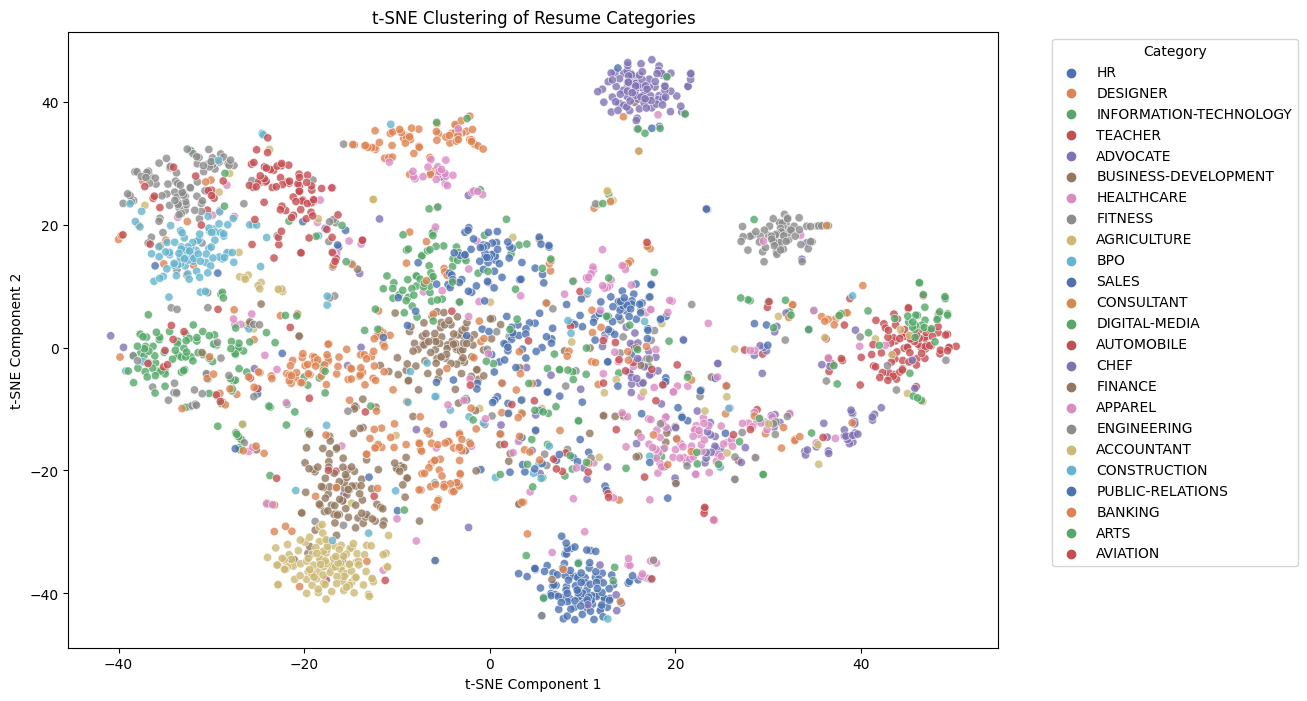

In [11]:
# Encode resumes using the transformer model
resumes['embeddings'] = resumes['text'].apply(lambda x: model.encode(x, convert_to_tensor=True).cpu().numpy())

# Stack embeddings into a NumPy array
resume_embeddings = np.vstack(resumes['embeddings'].values)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(resume_embeddings)

# Add t-SNE results to DataFrame
resumes['tsne_x'] = tsne_results[:, 0]
resumes['tsne_y'] = tsne_results[:, 1]

# Plot using Seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=resumes['tsne_x'], 
    y=resumes['tsne_y'], 
    hue=resumes['Category'], 
    palette='deep', 
    alpha=0.8
)

plt.title("t-SNE Clustering of Resume Categories")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Move the legend outside the plot
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import faiss
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


In [13]:
# Load Transformer model
transformer = SentenceTransformer("all-MiniLM-L6-v2")

In [14]:
# Encode text using transformer
resumes["embeddings"] = resumes["text"].apply(lambda x: transformer.encode(x, convert_to_tensor=True).cpu().numpy())
jobs["embeddings"] = jobs["text"].apply(lambda x: transformer.encode(x, convert_to_tensor=True).cpu().numpy())

In [15]:
# Compute TF-IDF embeddings
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_resumes = vectorizer.fit_transform(resumes["text"]).toarray()
tfidf_jobs = vectorizer.transform(jobs["text"]).toarray()

In [16]:
# Combine transformer and TF-IDF embeddings
resumes["final_embeddings"] = [np.concatenate((a, b)) for a, b in zip(resumes["embeddings"], tfidf_resumes)]
jobs["final_embeddings"] = [np.concatenate((a, b)) for a, b in zip(jobs["embeddings"], tfidf_jobs)]

In [17]:
# Ensure we only select matching resumes and jobs
min_samples = min(len(resumes), len(jobs))

# Select equal-sized subsets
resumes = resumes.iloc[:min_samples].reset_index(drop=True)
jobs = jobs.iloc[:min_samples].reset_index(drop=True)

# Stack embeddings again after filtering
resume_embeddings = np.vstack(resumes["final_embeddings"].values)
job_embeddings = np.vstack(jobs["final_embeddings"].values)

# Normalize embeddings
resume_embeddings = normalize(resume_embeddings)
job_embeddings = normalize(job_embeddings)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(resume_embeddings, job_embeddings, test_size=0.2, random_state=42)


In [18]:
# Input layers
resume_input = Input(shape=(X_train.shape[1],))
job_input = Input(shape=(X_train.shape[1],))

# Shared Embedding Layers
resume_dense = Dense(256, activation="relu")(resume_input)
resume_dense = Dropout(0.2)(resume_dense)
resume_dense = Dense(128, activation="relu")(resume_dense)

job_dense = Dense(256, activation="relu")(job_input)
job_dense = Dropout(0.2)(job_dense)
job_dense = Dense(128, activation="relu")(job_dense)

# Cosine Similarity Layer
cosine_similarity = tf.keras.layers.Dot(axes=-1, normalize=True)([resume_dense, job_dense])

# Output layer (contrastive loss)
output = Dense(1, activation="sigmoid")(cosine_similarity)

# Build Model
model = Model(inputs=[resume_input, job_input], outputs=output)

# Compile Model with Contrastive Loss
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5384)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5384)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,378,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  1,378,560 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          2 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,822,914 (10.77 MB)

 Trainable params: 2,822,914 (10.77 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train model
model.fit(
    [X_train, y_train], np.ones(len(X_train)),  # Positive pairs
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7071 - loss: 0.7173 - val_accuracy: 1.0000 - val_loss: 0.6693
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.6634 - val_accuracy: 1.0000 - val_loss: 0.6461
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.6404 - val_accuracy: 1.0000 - val_loss: 0.6237
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 1.0000 - loss: 0.6183 - val_accuracy: 1.0000 - val_loss: 0.6022
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.5969 - val_accuracy: 1.0000 - val_loss: 0.5814
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.5764 - val_accuracy: 1.0000 - val_loss: 0.5614
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.5566 - val_accuracy: 1.0000 - val_loss: 0.5422
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.5375 - val_accuracy: 1.0000 - v

In [20]:
# Create FAISS index for fast retrieval
dimension = X_train.shape[1]  # Embedding size
index = faiss.IndexFlatL2(dimension)
index.add(np.array(X_train, dtype=np.float32))  # Index resume embeddings

In [28]:
def find_best_match(job_embedding):
    job_embedding = np.array(job_embedding, dtype=np.float32).reshape(1, -1)
    _, indices = index.search(job_embedding, k=5)  # Find top-5 matching resumes
    return indices[0]

# Test on sample job
job_number = 2
sample_job_embedding = jobs["final_embeddings"].iloc[job_number]
best_matches = find_best_match(sample_job_embedding)

# Print matched resumes
print("Best Matches for Job:", jobs.iloc[job_number]["title"])
for idx in best_matches:
    print("- Matched Resume:", resumes.iloc[idx]["title"])

Best Matches for Job: Senior Elder Law / Trusts and Estates Associate Attorney
- Matched Resume: administrative assistant 
- Matched Resume: business development specialist 
- Matched Resume: leasing consultant 
- Matched Resume: consultant 
- Matched Resume: graduate research assistant 


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to process custom CV input
def process_custom_cv(cv_text):
    """Convert a raw CV text into an embedding."""
    cv_embedding = transformer.encode(cv_text, convert_to_tensor=True).cpu().numpy()  # Transformer encoding
    cv_tfidf = vectorizer.transform([cv_text]).toarray()[0]  # TF-IDF encoding
    final_embedding = np.concatenate((cv_embedding, cv_tfidf))  # Combine both
    final_embedding = normalize(final_embedding.reshape(1, -1))  # Normalize
    return final_embedding

# Function to find best resume matches using FAISS
def find_best_match_faiss(job_embedding, k=5):
    """Find top-k closest resumes using FAISS."""
    job_embedding = np.array(job_embedding, dtype=np.float32).reshape(1, -1)
    distances, indices = index.search(job_embedding, k)
    
    # Convert FAISS L2 distances to similarity percentage (100% - normalized L2 distance)
    similarity_scores = [100 - (d / np.max(distances) * 100) for d in distances[0]]
    
    return indices[0], similarity_scores

# Function to find best resume matches using Cosine Similarity
def find_best_match_cosine(job_embedding, k=5):
    """Find top-k closest resumes using cosine similarity."""
    similarities = cosine_similarity(job_embedding, resume_embeddings)[0]  # Compare with all resumes
    top_k_indices = np.argsort(-similarities)[:k]  # Get top-k results
    
    # Convert Cosine Similarity (-1 to 1) to a percentage match (0% to 100%)
    similarity_scores = [(sim + 1) / 2 * 100 for sim in similarities[top_k_indices]]
    
    return top_k_indices, similarity_scores

# Query Function: Allow querying by job description or custom CV
def query_cv_or_job(query_text, method="faiss", k=5):
    """
    Query job-resume matching using a job description or a custom CV.
    method: "faiss" for FAISS retrieval, "cosine" for cosine similarity ranking.
    """
    query_embedding = process_custom_cv(query_text)  # Encode query

    if method == "faiss":
        best_matches, match_scores = find_best_match_faiss(query_embedding, k)
    elif method == "cosine":
        best_matches, match_scores = find_best_match_cosine(query_embedding, k)
    else:
        raise ValueError("Invalid method. Use 'faiss' or 'cosine'.")

    print("\n🔹 Query: ", query_text[:10], "...\n")
    print(f"🔍 Top {k} Matching Resumes:")

    for idx, score in zip(best_matches, match_scores):
        print(f"- {resumes.iloc[idx]['title']} (Match: {score:.2f}%)")

# Example Usage
custom_cv_text = """

Ivy Haddington
Jacksonville, FL | 904-555-0175 | ihaddington@email.com
Summary
&nbsp;
Enthusiastic recent graduate seeking a full-time Medical Assistant position to gain relevant field experience and improve professional skills. Looking to apply skills like empathetic communication and creative problem-solving to care for patients and support the needs of a medical team.
Education
&nbsp;
Nursing University of Jacksonville
Bachelor of Science in health and human services
Experience
&nbsp;
Memorial Hospital of Jacksonville, Jacksonville, FL, Junior Medical Assistant
September 2021 – Current
Care for a caseload of five patients under the direct supervision of an experienced medical assistant
Administer medications accurately and efficiently to patients under my care
Record vital signs and used the patient management software to maintain accurate records
Perform essential care tasks such as grooming, ambulating and feeding patients
Clean exam and patient rooms for patients following all sanitation and infection prevention standards
Nursing University of Jacksonville, Jacksonville, FL, Statistics Tutor
September 2019 – May 2021
Worked with up to 25 students weekly to support learning objectives in statistics and general mathematics
Prepared tutoring documents to use with students and shared materials with peers
Scheduled tutoring sessions using tutoring center scheduling software
Superior Senior Care Home of Jacksonville, Jacksonville, FL, Nursing Home Volunteer
June 2018 – September 20195
Volunteered 10 hours weekly to socialize with care home residents, play games and supervise activities
Assisted with preparing meals, eating with residents and cleaning up after meal times
Monitored front desk as needed by greeting visitors, taking phone calls and managing resident files
Certifications
&nbsp;
Certified Medical Assistant
Skills
&nbsp;
Bilingual in English and Spanish
Empathetic communication
OSHA and HIPPA Training
Database management
Patient care

"""
query_cv_or_job(custom_cv_text, method="cosine", k=5)  # Query with custom CV using Cosine Similarity
query_cv_or_job(custom_cv_text, method="faiss", k=5)


🔹 Query:  

Ivy Hadd ...

🔍 Top 5 Matching Resumes:
- licensed practical nurse step unit  (Match: 71.92%)
- registered nurse  (Match: 71.21%)
- healthcare provider  (Match: 70.75%)
- registered nurse  (Match: 70.74%)
- patient care technician  (Match: 70.36%)

🔹 Query:  

Ivy Hadd ...

🔍 Top 5 Matching Resumes:
- digital marketing manager  (Match: 3.19%)
- freelance consultant  (Match: 1.61%)
- business development manager  (Match: 1.58%)
- manager  (Match: 0.11%)
- associate manager desig (Match: 0.00%)
